In [3]:
import pandas as pd

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

measure_latency = 1244.4444444444443

df = pd.read_csv('segmented_evaluate.csv')
df = df.drop(columns=['pbid'])
df = df[df['ARG'] <= 100000]    

df_quantum = pd.read_csv('latency.csv')
df_quantum = df_quantum.groupby(['pkid', 'method'], as_index=False).agg({
    'latency_all': 'mean',
})
df_quantum['quantum'] = (df_quantum['latency_all'] * 300 * 1024) / 1e9

df = pd.merge(df, df_quantum[['pkid', 'quantum']], on='pkid', how='left', suffixes=('', '_new'))
df['quantum'] = df['quantum_new']
df.drop(columns=['quantum_new'], inplace=True)

df['pkid'] = df['pkid'] % 2
df['quantum'] += measure_latency * (df['run_times'] - 300 * 1024) / 1e9

grouped_df = df.groupby(['pkid', 'num_segments', 'method'], as_index=False).agg({
    'iteration_count': 'mean',
    'classcial': 'max',
    'quantum': 'mean',
    'run_times': 'mean',
})

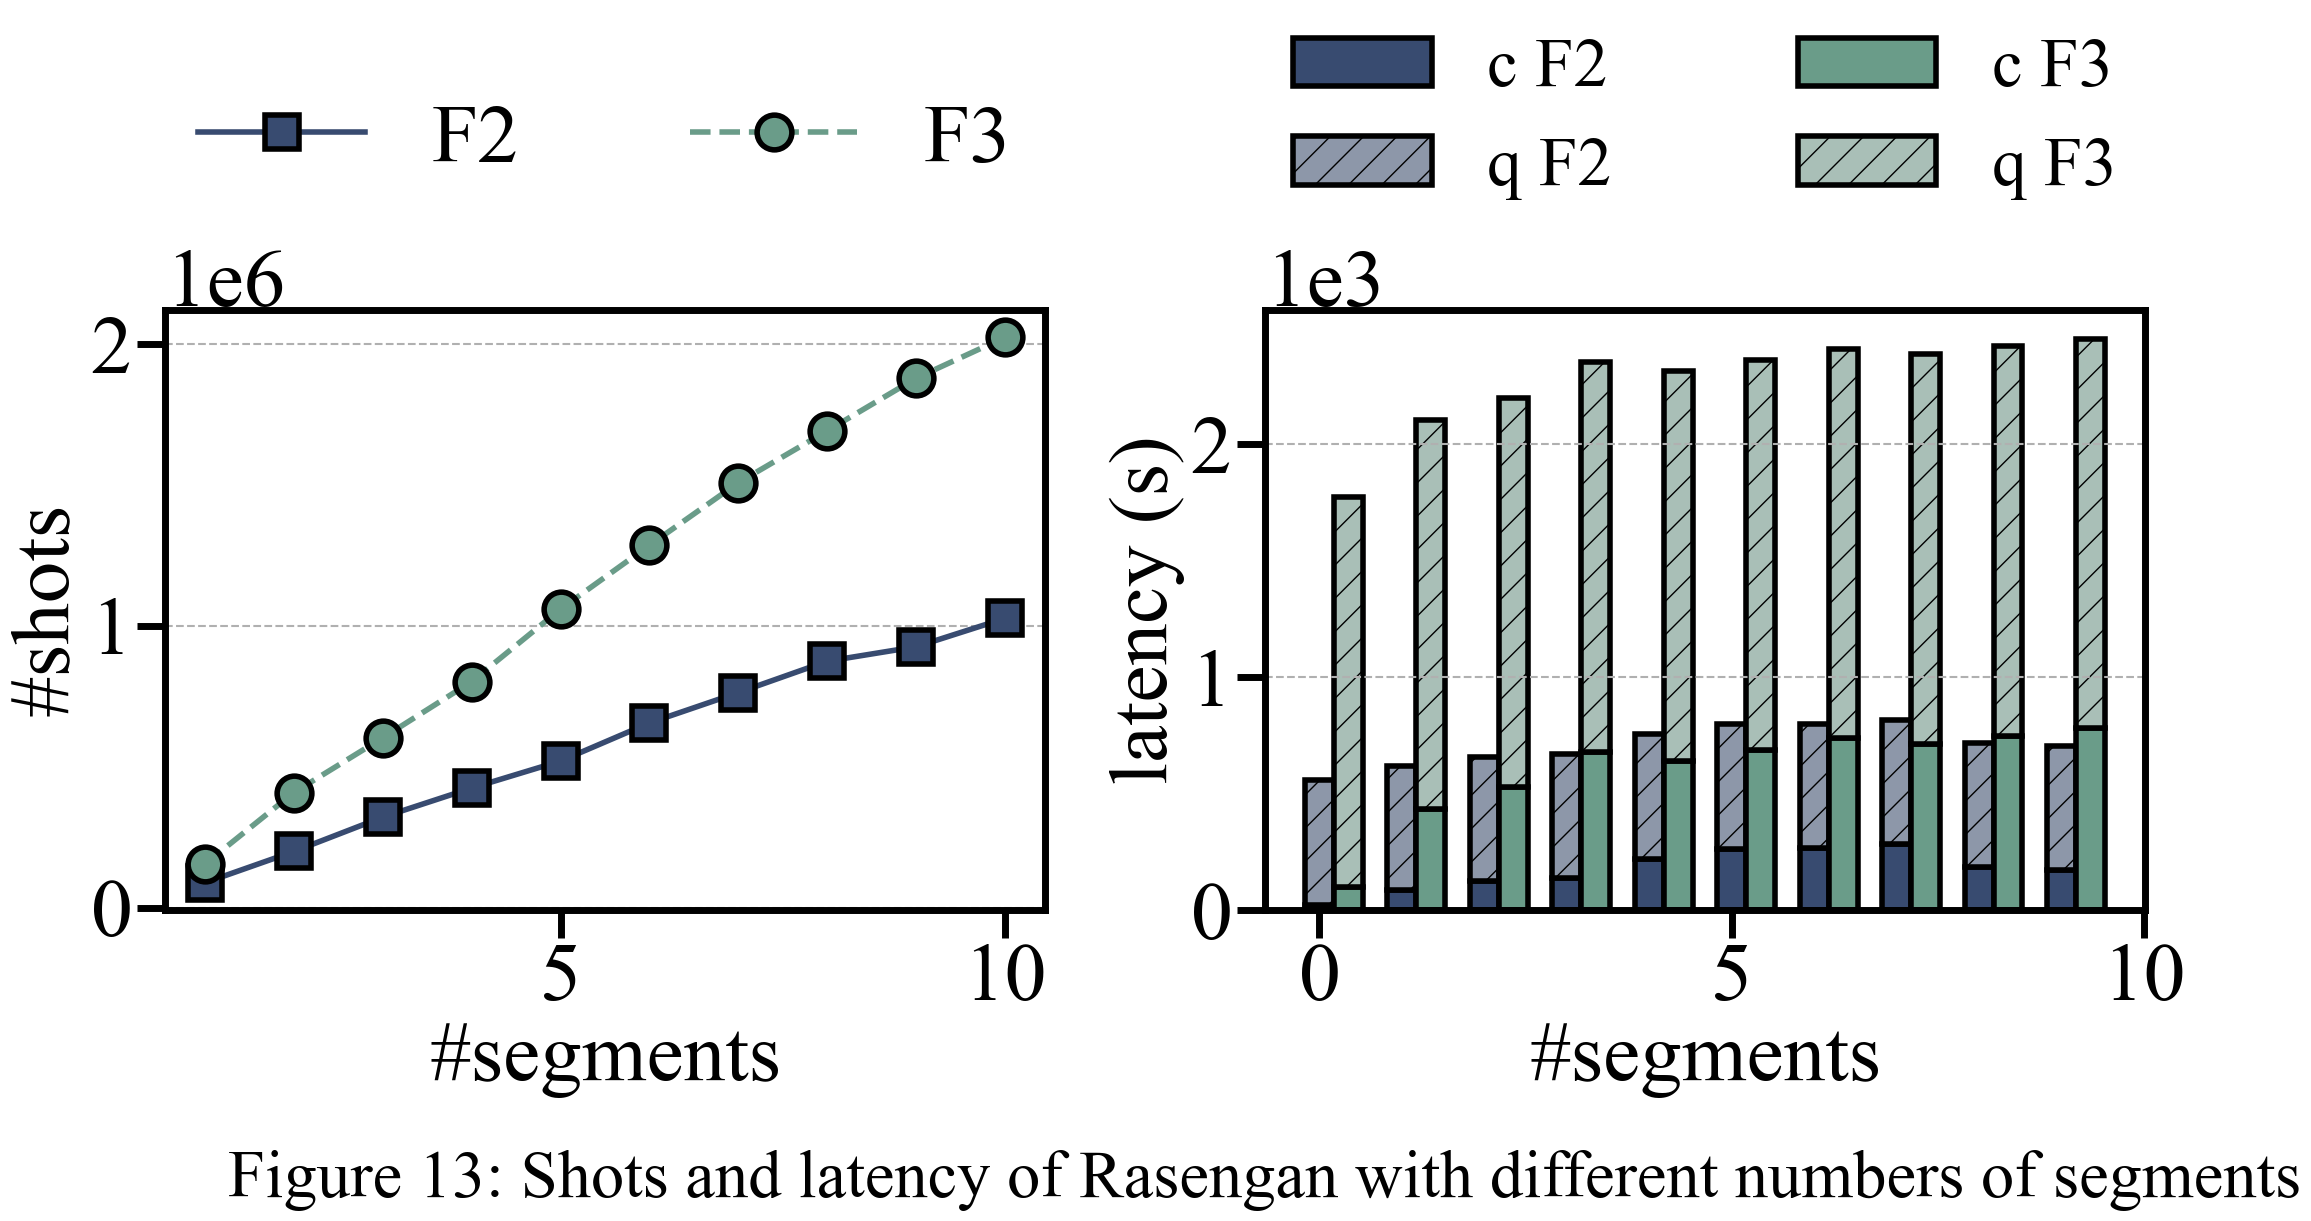

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

# Set global plot style
mpl.rcParams.update({
    'pdf.fonttype': 42,
    'ps.fonttype': 42,
    'font.family': 'Times New Roman',
    'font.size': 60,
    'axes.unicode_minus': False,
    'mathtext.fontset': 'custom',
    'mathtext.rm': 'Times New Roman',
    'mathtext.it': 'Times New Roman:italic',
    'mathtext.bf': 'Times New Roman:bold',
    'axes.linewidth': 5,
    'xtick.major.size': 20,
    'xtick.major.width': 5,
    'xtick.minor.size': 10,
    'xtick.minor.width': 3,
    'ytick.major.size': 20,
    'ytick.major.width': 5,
    'ytick.minor.size': 10,
    'ytick.minor.width': 3,
    "lines.markersize": 25,
    "lines.markeredgewidth": 4,
    "markers.fillstyle": 'full',
    'lines.markerfacecolor': '#f8d941',
    'lines.markeredgecolor': 'black',
})

# Initialize figure and axes
scale = 1
fig = plt.figure(figsize=(22 * scale, 12 * scale))
ax1 = plt.axes((0, 0, 0.4, 0.5))
ax2 = plt.axes((0.5, 0, 0.4, 0.5))

# Colors and line styles
colors_ = ['#384B70', '#6A9C89']         # For run_times
colors_2 = ['#8d97a9', '#a9bfb7']         # For run_times
colors_quantum = ['#B8001F', '#FF7F00']  # For quantum (not used here)
line_styles = ['-', '--']

label_list = ["F2", "F3"]

# Plot run_times line chart on ax1
for idx, pkid_value in enumerate([0, 1]):
    data = grouped_df[grouped_df['pkid'] == pkid_value]
    x = data['num_segments']
    marker_style = 's' if pkid_value == 0 else 'o'
    
    ax1.plot(
        x, data['run_times'],
        color=colors_[idx],
        linestyle=line_styles[idx],
        label=label_list[idx],
        linewidth=4,
        marker=marker_style,
        markerfacecolor=colors_[idx],
        markeredgecolor='black'
    )

ax1.grid(True, linestyle='--', linewidth=1.5, axis='y')
ax1.set_xlabel('#segments')
ax1.set_ylabel('#shots')
ax1.legend(
    loc='upper left', ncol=2, frameon=False,
    bbox_to_anchor=(0, 1.1, 1, 0.3), mode="expand", borderaxespad=0
)

# Plot stacked bar chart of classical + quantum on ax2
bar_width = 0.35

class_label_list = ["c F2", "c F3"]
quantum_label_list = ["q F2", "q F3"]

for idx, pkid_value in enumerate([0, 1]):
    data = grouped_df[grouped_df['pkid'] == pkid_value]
    x = np.arange(len(data['num_segments']))
    y_classical = data['classcial'].to_list()
    y_quantum = data['quantum'].to_list()

    ax2.bar(
        x + idx * bar_width, y_classical,
        width=bar_width, color=colors_[idx],
        label=class_label_list[idx],
        edgecolor="black", linewidth=4
    )

    ax2.bar(
        x + idx * bar_width, y_quantum,
        width=bar_width, bottom=y_classical,
        color=colors_2[idx], hatch='/',
        label=quantum_label_list[idx],
        edgecolor="black", linewidth=4
    )

ax2.grid(True, linestyle='--', linewidth=1.5, axis='y')
ax2.set_xlabel('#segments')
ax2.set_ylabel('latency (s)')
ax2.legend(
    loc='upper left', ncol=2, frameon=False,
    bbox_to_anchor=(0, 1.1, 1, 0.4), mode="expand", borderaxespad=0,
    fontsize='small'
)
ax2.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

# Save and display
# plt.tight_layout()
title = 'Figure 13: Shots and latency of Rasengan with different numbers of segments'
plt.suptitle(title, y=-0.2, fontsize=48)
plt.savefig(f'{title}.svg', bbox_inches='tight')
plt.show()